In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torch torchvision torchaudio


SyntaxError: invalid syntax (2837561437.py, line 1)

In [ ]:
pip install nltk

In [ ]:
pip install gensim

In [ ]:
pip install spacy

In [ ]:
pip install matplotlib

In [ ]:
pip install wordcloud

In [ ]:
pip install sentence_transformers

In [ ]:
pip install torchtext

In [7]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaForSequenceClassification,Trainer, TrainingArguments
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import wandb
import re
import os
import nltk
import datasets
from nltk import tokenize


In [8]:
import pandas as pd
import numpy as np
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel, pipeline, get_linear_schedule_with_warmup
)
from datasets import Dataset

torch.manual_seed(42)
torch.backends.cuda.deterministic = True
%matplotlib inline

In [ ]:
!ls

In [9]:
# df.to_csv("/Users/andriy/Desktop/Project_NLP/ukr-news", index=False)
df = pd.read_csv("ukr-news.csv")

In [10]:
categories = ['economic', 'health', 'polit', 'science', 'war']

In [11]:
df = df[df['category'].isin(categories)]

In [12]:
df

,title,text,category
2264,"Епічний кінець: вчені розповіли, як помре Земля",Сонце поглине Землю під час наближення до заве...,science
2265,Чому вимерли динозаври: штучний інтелект дав в...,"Палеонтологи стверджують, що основною причиною...",science
2266,У Британії розкопали фундамент 1400-річного яз...,У Британії данському графстві Саффолк археолог...,science
2267,До Землі наблизиться небезпечний астероїд: що ...,"У середу, 6 грудня, поблизу Землі пролетить ас...",science
2268,"У ПАР знайшли тваринку, яка вважалася вимерлою...",Вперше за майже 100 років у Південній Африці з...,science
...,...,...,...
22265,Україна збиватиме ракетами російські дрони з К...,Українські військові мають намір збивати росій...,war
22266,"Окупанти прийняли ""закон"" про держкордон ""ДНР""...",Так звана «Народна Рада» самопроголошеної «ДНР...,war
22267,Україна провела військові маневри з протидесан...,Українські військові на одному з полігонів бой...,war
22268,Бойовики зазнали масштабних втрат на Донбасі,"За тиждень з 22 по 28 листопада 2019 року, втр...",war


# Modeling

In [13]:
X = df['text']
y = df['category']

# Perform train-test split
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames with both text data and labels
train_df = pd.DataFrame({'text': train_data, 'label': train_labels})
test_df = pd.DataFrame({'text': test_data, 'label': test_labels})


In [14]:
train_df

,text,label
17943,"Станом на 5 грудня Київ та ще сім областей ""че...",health
15273,Китай охопила нова епідемія / фото REUTERS Кит...,health
4298,У Києві 8 квітня завершується опалювальний сез...,economic
15970,"Більшість схиляється до того, що коронавірус в...",health
8409,"Аграрии начали посевную кампанию, которая обой...",economic
...,...,...
15033,Манекен одного з головних персонажів всесвіту ...,science
15713,В Україні хочуть легалізувати медичний канабіс...,health
9139,Российские войска и вскормленные Кремлем боеви...,economic
3124,Команда вчених пропонує нове пояснення деяких ...,health


In [15]:
dummy_df = pd.get_dummies(train_df['label'], prefix='is_')
dummy_df = dummy_df.astype(int)
train_df = pd.concat([train_df, dummy_df], axis=1)

dummy_df = pd.get_dummies(test_df['label'], prefix='is_')
dummy_df = dummy_df.astype(int)
test_df = pd.concat([test_df, dummy_df], axis=1)

In [16]:
train_df

,text,label,is__economic,is__health,is__polit,is__science,is__war
17943,"Станом на 5 грудня Київ та ще сім областей ""че...",health,0,1,0,0,0
15273,Китай охопила нова епідемія / фото REUTERS Кит...,health,0,1,0,0,0
4298,У Києві 8 квітня завершується опалювальний сез...,economic,1,0,0,0,0
15970,"Більшість схиляється до того, що коронавірус в...",health,0,1,0,0,0
8409,"Аграрии начали посевную кампанию, которая обой...",economic,1,0,0,0,0
...,...,...,...,...,...,...,...
15033,Манекен одного з головних персонажів всесвіту ...,science,0,0,0,1,0
15713,В Україні хочуть легалізувати медичний канабіс...,health,0,1,0,0,0
9139,Российские войска и вскормленные Кремлем боеви...,economic,1,0,0,0,0
3124,Команда вчених пропонує нове пояснення деяких ...,health,0,1,0,0,0


In [14]:
test_df.columns

Index(['text', 'label', 'is__economic', 'is__health', 'is__polit',
       'is__science', 'is__war'],
      dtype='object')

In [17]:
TARGET_COLUMNS = ['is__economic', 'is__health', 'is__polit',
       'is__science', 'is__war']

In [18]:
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

[nltk_data] Downloading package punkt to /Users/taras/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
train_df['clean_text'] = train_df['text'].apply(process_text)
test_df['clean_text'] = test_df['text'].apply(process_text)

In [20]:
train_df["strat_feature"] = train_df[TARGET_COLUMNS].apply(
    lambda x: reduce(lambda x, y: str(x) + str(y), x), axis=1
)
small_strat_groups = train_df["strat_feature"].value_counts()[
    train_df["strat_feature"].value_counts() < 5
].index
train_df.loc[train_df["strat_feature"].isin(small_strat_groups), "strat_feature"] = "-1"
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(train_df, train_df["strat_feature"])]

In [21]:
def comp_metric(y_true, y_pred, verbose=True):
    assert y_true.shape == y_pred.shape
    class_roc_aucs = [roc_auc_score(y_true[:,i], y_pred[:,i]) for i in range(y_pred.shape[1])]
    if verbose:
        for ra, tgt_col in zip(class_roc_aucs, TARGET_COLUMNS):
            print(f"{tgt_col} Roc Auc: {ra}")
        print(f"Result Roc Auc: {np.mean(class_roc_aucs)}")
    return class_roc_aucs, np.mean(class_roc_aucs)

In [26]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("mshamrai/bert-base-ukr-eng-rus-uncased")
model = BertForSequenceClassification.from_pretrained("mshamrai/bert-base-ukr-eng-rus-uncased")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mshamrai/bert-base-ukr-eng-rus-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(43417, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [22]:
# tokenizer = RobertaTokenizer.from_pretrained("mshamrai/bert-base-ukr-eng-rus-uncased", max_length = 512)
# model = RobertaForSequenceClassification.from_pretrained("youscan/ukr-roberta-base",
#     num_labels=len(TARGET_COLUMNS),
#     ignore_mismatched_sizes=True
# )

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/803 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizer'.


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [27]:
from dataset import TextDataset

In [28]:
train_torch_dataset = TextDataset(
    texts=train_df["clean_text"].to_list(),
    targets=train_df[TARGET_COLUMNS].values,
    dataset_tokenizer=tokenizer,
    max_length=512,
)

Precomputing Tokenized ids ...


Token indices sequence length is longer than the specified maximum sequence length for this model (2469 > 512). Running this sequence through the model will result in indexing errors


Tokenized ids precomputed!


In [29]:
def torch_loop(
    dataloader,
    inp_model,
    inp_optimizer,
    inp_criterion,
    inp_scheduler=None,
    mode="train",
    device="mps",
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_losses = []
    all_targets = []
    # We need this context in order to control gradient computation
    # mode == True - gradient will NOT be computed, mode == False - gradient will be computed
    with torch.inference_mode(mode=(mode != "train")):
        for text in tqdm(dataloader):
            text = {k:v.to(device) for k,v in text.items()}
            label = text.pop("target")
            if mode == "train":
                inp_optimizer.zero_grad()
            # 1.1 Compute Forward path
            predicted_label = inp_model(**text).logits
            # 1.2 Compute Cost function (part of Forward path)
            loss = inp_criterion(predicted_label, label)
            if mode == "train":
                loss.mean().backward()
                inp_optimizer.step()
                if inp_scheduler is not None:
                    inp_scheduler.step()

            # Accumulate stats
            # We receive logits and we have to transform them into `probs`. That is why sigmoid is used
            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())
    all_predicted_label = np.concatenate(all_predicted_label)
    all_losses = np.concatenate(all_losses)
    all_targets = np.concatenate(all_targets)

    return all_predicted_label, all_losses, all_targets

def print_losses(input):
    for cls_idx, cls_name in enumerate(TARGET_COLUMNS):
        print(f"{cls_name} BCE loss: {input[:,cls_idx].mean()}")
    print(f"Result BCE loss: {input.mean()}")

def visualise_lr_scheduling(lr_scheduler_from_opt, n_steps, verbose=True, lr=1e-3):
    t_opt = torch.optim.SGD([torch.tensor(1)], lr=lr)
    t_sched = lr_scheduler_from_opt(t_opt)
    lrs = []
    for i in range(n_steps):
        t_opt.step()
        lrs.append(t_sched.get_lr()[0])
        t_sched.step()

    if verbose:
        plt.title("Learning Rate Schedule")
        plt.xlabel("Iteration")
        plt.ylabel("Learning Rate")
        plt.plot(lrs)
        plt.show()

    return lrs

In [31]:
nn_model = AutoModelForSequenceClassification.from_pretrained(
    "mshamrai/bert-base-ukr-eng-rus-uncased",
    num_labels=len(TARGET_COLUMNS),
    ignore_mismatched_sizes=True
).to("mps")
criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.AdamW([
    {'params': nn_model.bert.parameters(), "lr": 1e-5},
    {'params': nn_model.classifier.parameters(), "lr": 1e-3},
], weight_decay=0)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mshamrai/bert-base-ukr-eng-rus-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
train_torch_dataset = TextDataset(
    texts=train_df.iloc[folds_train_test_ids[0][0]]["clean_text"].to_list(),
    targets=train_df.iloc[folds_train_test_ids[0][0]][TARGET_COLUMNS].values,
    dataset_tokenizer=tokenizer,
    max_length=512,
)
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

valid_torch_dataset = TextDataset(
    texts=train_df.iloc[folds_train_test_ids[0][1]]["clean_text"].to_list(),
    targets=train_df.iloc[folds_train_test_ids[0][1]][TARGET_COLUMNS].values,
    dataset_tokenizer=tokenizer,
    max_length=512,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

Precomputing Tokenized ids ...
Tokenized ids precomputed!
Precomputing Tokenized ids ...
Tokenized ids precomputed!


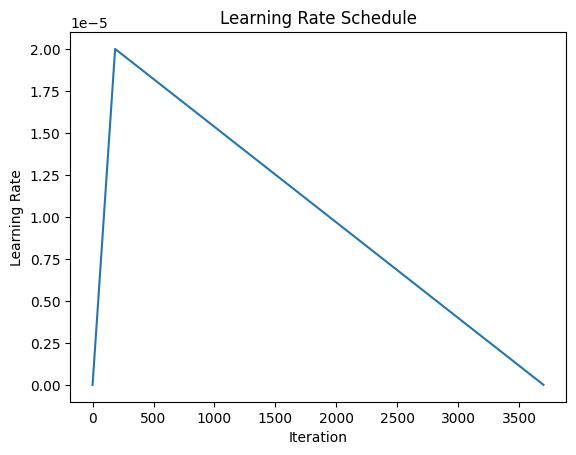

In [33]:
n_epochs = 10
# Here is an example of scheduler, which udates after each iteration (batch) , NOT after each epoch
# Also it has 2
visualise_lr_scheduling(
    lr_scheduler_from_opt=lambda opt: get_linear_schedule_with_warmup(
        optimizer=opt,
        num_warmup_steps=int(0.05*len(train_torch_dataloader)*n_epochs),
        num_training_steps=len(train_torch_dataloader)*n_epochs
    ),
    n_steps=len(train_torch_dataloader)*n_epochs,
    lr=2e-5
)
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=int(0.05*len(train_torch_dataloader)*n_epochs),
    num_training_steps=len(train_torch_dataloader)*n_epochs
)

In [34]:
from sklearn.metrics import mean_squared_error

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_roc_aucs = []
train_roc_aucs = []

best_metric = np.inf
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader,
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        inp_scheduler=scheduler,
        device="mps",
        mode="train"
    )
    # 1.2 Compute and print train metrics
    print("Train metrics")
    train_roc_auc = mean_squared_error(
        train_epoch_targets,
        train_epoch_labels
    )
    print(train_roc_auc)
    print("Train BCE losses")
    print_losses(train_epoch_losses)
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader,
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="mps",
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    print("Valid metrics")
    valid_roc_auc = mean_squared_error(
        valid_epoch_targets,
        valid_epoch_labels
    )
    print(valid_roc_auc)
    print("Valid BCE losses")
    print_losses(valid_epoch_losses)
    # # 3. Update learning rate (if needed)
    # scheduler.step(valid_roc_auc)
    # 4. Save best model
    if valid_roc_auc < best_metric:
        best_metric = valid_roc_auc
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate all stats
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses)
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_roc_aucs.append(valid_roc_auc)
    train_roc_aucs.append(train_roc_auc)

Starting Epoch 1
Train phase


100%|██████████| 370/370 [14:05<00:00,  2.29s/it]


Train metrics
0.14344773
Train BCE losses
is__economic BCE loss: 0.35097602009773254
is__health BCE loss: 0.478655606508255
is__polit BCE loss: 0.4679488241672516
is__science BCE loss: 0.4421941041946411
is__war BCE loss: 0.48948025703430176
Result BCE loss: 0.44585099816322327
Valid phase


  0%|          | 0/93 [00:00<?, ?it/s]Python(14609) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14610) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14614) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14616) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14617) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 93/93 [01:42<00:00,  1.10s/it]


Valid metrics
0.100833036
Valid BCE losses
is__economic BCE loss: 0.1800156533718109
is__health BCE loss: 0.3374682068824768
is__polit BCE loss: 0.3371124863624573
is__science BCE loss: 0.36470726132392883
is__war BCE loss: 0.3754587173461914
Result BCE loss: 0.3189524710178375
Starting Epoch 2
Train phase


  0%|          | 0/370 [00:00<?, ?it/s]Python(14665) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14666) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14670) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 370/370 [14:24<00:00,  2.34s/it]


Train metrics
0.078707136
Train BCE losses
is__economic BCE loss: 0.1575005203485489
is__health BCE loss: 0.2656213343143463
is__polit BCE loss: 0.2604145407676697
is__science BCE loss: 0.2796124517917633
is__war BCE loss: 0.3224899470806122
Result BCE loss: 0.2571277618408203
Valid phase


  0%|          | 0/93 [00:00<?, ?it/s]Python(15040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15041) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15049) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15053) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 93/93 [01:45<00:00,  1.14s/it]


Valid metrics
0.056158137
Valid BCE losses
is__economic BCE loss: 0.10223396867513657
is__health BCE loss: 0.22378422319889069
is__polit BCE loss: 0.18646667897701263
is__science BCE loss: 0.22897763550281525
is__war BCE loss: 0.21686561405658722
Result BCE loss: 0.1916656196117401
Starting Epoch 3
Train phase


  0%|          | 0/370 [00:00<?, ?it/s]Python(15097) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15101) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15103) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15104) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15105) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15106) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 370/370 [14:39<00:00,  2.38s/it]


Train metrics
0.050393928
Train BCE losses
is__economic BCE loss: 0.10831188410520554
is__health BCE loss: 0.19109350442886353
is__polit BCE loss: 0.15323098003864288
is__science BCE loss: 0.19755958020687103
is__war BCE loss: 0.21393412351608276
Result BCE loss: 0.17282602190971375
Valid phase


  0%|          | 0/93 [00:00<?, ?it/s]Python(15457) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15458) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 93/93 [01:44<00:00,  1.12s/it]


Valid metrics
0.047966428
Valid BCE losses
is__economic BCE loss: 0.09677951782941818
is__health BCE loss: 0.19513224065303802
is__polit BCE loss: 0.12781809270381927
is__science BCE loss: 0.2111605554819107
is__war BCE loss: 0.1945277750492096
Result BCE loss: 0.165083646774292
Starting Epoch 4
Train phase


  0%|          | 0/370 [00:00<?, ?it/s]Python(15500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15502) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15505) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15507) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15508) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 370/370 [14:33<00:00,  2.36s/it]


Train metrics
0.03853585
Train BCE losses
is__economic BCE loss: 0.08438652008771896
is__health BCE loss: 0.16203975677490234
is__polit BCE loss: 0.10257339477539062
is__science BCE loss: 0.16137395799160004
is__war BCE loss: 0.16095808148384094
Result BCE loss: 0.13426634669303894
Valid phase


  0%|          | 0/93 [00:00<?, ?it/s]Python(15884) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15886) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 93/93 [01:41<00:00,  1.09s/it]


Valid metrics
0.042426776
Valid BCE losses
is__economic BCE loss: 0.07352019101381302
is__health BCE loss: 0.16605384647846222
is__polit BCE loss: 0.12467306852340698
is__science BCE loss: 0.1826956570148468
is__war BCE loss: 0.18954026699066162
Result BCE loss: 0.14729660749435425
Starting Epoch 5
Train phase


  0%|          | 0/370 [00:00<?, ?it/s]Python(15921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15927) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15929) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 370/370 [13:38<00:00,  2.21s/it]


Train metrics
0.030889887
Train BCE losses
is__economic BCE loss: 0.06986569613218307
is__health BCE loss: 0.1357647180557251
is__polit BCE loss: 0.07928012311458588
is__science BCE loss: 0.13342396914958954
is__war BCE loss: 0.12818458676338196
Result BCE loss: 0.10930381715297699
Valid phase


  0%|          | 0/93 [00:00<?, ?it/s]Python(16189) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16191) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16192) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16193) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16194) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16198) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 93/93 [01:40<00:00,  1.08s/it]


Valid metrics
0.040941723
Valid BCE losses
is__economic BCE loss: 0.08128567039966583
is__health BCE loss: 0.1756616085767746
is__polit BCE loss: 0.09899293631315231
is__science BCE loss: 0.20132657885551453
is__war BCE loss: 0.17674537003040314
Result BCE loss: 0.1468024104833603
Starting Epoch 6
Train phase


  0%|          | 0/370 [00:00<?, ?it/s]Python(16229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16231) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16233) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 370/370 [14:10<00:00,  2.30s/it]


Train metrics
0.026778629
Train BCE losses
is__economic BCE loss: 0.06109902635216713
is__health BCE loss: 0.12667012214660645
is__polit BCE loss: 0.06276320666074753
is__science BCE loss: 0.11988521367311478
is__war BCE loss: 0.10848009586334229
Result BCE loss: 0.09577952325344086
Valid phase


  0%|          | 0/93 [00:00<?, ?it/s]Python(16595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16602) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16603) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16605) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16606) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16607) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 93/93 [01:42<00:00,  1.10s/it]


Valid metrics
0.037477303
Valid BCE losses
is__economic BCE loss: 0.07261140644550323
is__health BCE loss: 0.16447289288043976
is__polit BCE loss: 0.09861218929290771
is__science BCE loss: 0.17917051911354065
is__war BCE loss: 0.16313159465789795
Result BCE loss: 0.13559973239898682
Starting Epoch 7
Train phase


  0%|          | 0/370 [00:00<?, ?it/s]Python(16636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16643) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16644) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(16647) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 370/370 [13:37<00:00,  2.21s/it]


Train metrics
0.022082401
Train BCE losses
is__economic BCE loss: 0.049281902611255646
is__health BCE loss: 0.10960057377815247
is__polit BCE loss: 0.047194961458444595
is__science BCE loss: 0.1053316667675972
is__war BCE loss: 0.08799330145120621
Result BCE loss: 0.0798804759979248
Valid phase


  0%|          | 0/93 [00:00<?, ?it/s]Python(17020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17025) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17027) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17029) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17030) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17031) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17032) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 93/93 [01:41<00:00,  1.09s/it]


Valid metrics
0.038887825
Valid BCE losses
is__economic BCE loss: 0.08549489080905914
is__health BCE loss: 0.1698664277791977
is__polit BCE loss: 0.08871777355670929
is__science BCE loss: 0.17333737015724182
is__war BCE loss: 0.18167917430400848
Result BCE loss: 0.13981914520263672
Starting Epoch 8
Train phase


  0%|          | 0/370 [00:00<?, ?it/s]Python(17066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17072) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17074) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17075) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 370/370 [14:19<00:00,  2.32s/it]


Train metrics
0.019512009
Train BCE losses
is__economic BCE loss: 0.04442219063639641
is__health BCE loss: 0.10089386254549026
is__polit BCE loss: 0.037049729377031326
is__science BCE loss: 0.09668253362178802
is__war BCE loss: 0.07182898372411728
Result BCE loss: 0.07017546147108078
Valid phase


  0%|          | 0/93 [00:00<?, ?it/s]Python(17391) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17392) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17399) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 93/93 [01:44<00:00,  1.12s/it]


Valid metrics
0.0366139
Valid BCE losses
is__economic BCE loss: 0.07227861136198044
is__health BCE loss: 0.17527355253696442
is__polit BCE loss: 0.09138607978820801
is__science BCE loss: 0.18871811032295227
is__war BCE loss: 0.15983973443508148
Result BCE loss: 0.13749921321868896
Starting Epoch 9
Train phase


  0%|          | 0/370 [00:00<?, ?it/s]Python(17457) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
 44%|████▍     | 162/370 [06:11<07:56,  2.29s/it]


KeyError: Caught KeyError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/Users/taras/Downloads/Project_NLP/venv/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/taras/Downloads/Project_NLP/venv/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/Users/taras/Downloads/Project_NLP/venv/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/Users/taras/Downloads/Project_NLP/venv/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 127, in collate
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/Users/taras/Downloads/Project_NLP/venv/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 127, in <dictcomp>
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/Users/taras/Downloads/Project_NLP/venv/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 127, in <listcomp>
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
KeyError: 'token_type_ids'


In [24]:
valid_all_epoch_targets

[array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.

In [35]:
train_roc_aucs

[0.14344773,
 0.078707136,
 0.050393928,
 0.03853585,
 0.030889887,
 0.026778629,
 0.022082401,
 0.019512009]

In [36]:
valid_roc_aucs

[0.100833036,
 0.056158137,
 0.047966428,
 0.042426776,
 0.040941723,
 0.037477303,
 0.038887825,
 0.0366139]

In [38]:
nn_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(43417, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [30]:
!pwd

/Users/taras/Downloads/Project_NLP


In [39]:
save_directory = '/Users/taras/Downloads/Project_NLP/model_diff_lang'
nn_model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/Users/taras/Downloads/Project_NLP/model_diff_lang/tokenizer_config.json',
 '/Users/taras/Downloads/Project_NLP/model_diff_lang/special_tokens_map.json',
 '/Users/taras/Downloads/Project_NLP/model_diff_lang/vocab.txt',
 '/Users/taras/Downloads/Project_NLP/model_diff_lang/added_tokens.json')

In [39]:
valid_all_epoch_labels[9]

array([[4.70892410e-05, 3.67159188e-01, 8.04361298e-06, 6.00904226e-04,
        8.28051090e-01],
       [1.14066352e-04, 9.99780834e-01, 3.35328397e-04, 1.18717537e-04,
        5.16932087e-05],
       [1.02319864e-04, 9.54256539e-05, 1.39818207e-04, 1.30526489e-04,
        9.99747813e-01],
       ...,
       [7.72902131e-05, 2.08827536e-04, 9.99150991e-01, 1.52173146e-04,
        5.08410158e-04],
       [8.24524104e-05, 4.46900493e-04, 7.75434310e-05, 9.99559104e-01,
        1.56204860e-05],
       [5.71390738e-05, 1.02134545e-04, 1.43849145e-04, 1.36959803e-04,
        9.99782979e-01]], dtype=float32)

In [38]:
valid_all_epoch_targets[9]

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [40]:
import json

with open('valid_all_epoch_labels.json', 'w') as f:
    json.dump(valid_all_epoch_labels, f)
with open('valid_all_epoch_targets.json', 'w') as f:
    json.dump(valid_all_epoch_targets, f)

TypeError: Object of type ndarray is not JSON serializable

In [40]:
np.save('valid_all_epoch_labels_diff_lang.npy', valid_all_epoch_labels)

In [41]:
np.save('valid_all_epoch_targets_diff_lang.npy', valid_all_epoch_targets)

In [43]:
valid_all_epoch_targets

[array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.

In [54]:
nn_model.to('cpu')

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [60]:
new_texts = ['Майже 10 місяців минуло з тих пір, як внаслідок рутинної медичної процедури 22 пацієнти лікарні у Чорткові на Тернопільщині втратили зір. З тих пір двоє пацієнтів померли, ще сімом видалили очі. Решті ж постраждалих, попри безкінечні спроби, так і не змогли повернути собі зір.І навіть попри резонанс та кричущість всієї ситуації, медики, які вкололи пацієнтам препарат невідомого походження, продовжують працювати, а жодних звинувачень їм досі офіційно не висунули. Як розвивається розслідування масштабного випадку медичної недбалості, повідомляє сайт "Тернополяни".', "Another example text.", "And one more."]

# Tokenize and encode the new texts
tokenized_texts = tokenizer(new_texts, padding=True, truncation=True, return_tensors='pt')

# Make predictions
with torch.no_grad():
    logits = nn_model(**tokenized_texts).logits

# Convert logits to probabilities using softmax
probs = torch.nn.functional.softmax(logits, dim=1)

# Get predicted labels (assuming a classification task)
predicted_labels = torch.argmax(probs, dim=1).tolist()

# Display the results
for text, label in zip(new_texts, predicted_labels):
    print(f"Text: {text}, Predicted Label: {label}")

Text: Майже 10 місяців минуло з тих пір, як внаслідок рутинної медичної процедури 22 пацієнти лікарні у Чорткові на Тернопільщині втратили зір. З тих пір двоє пацієнтів померли, ще сімом видалили очі. Решті ж постраждалих, попри безкінечні спроби, так і не змогли повернути собі зір.І навіть попри резонанс та кричущість всієї ситуації, медики, які вкололи пацієнтам препарат невідомого походження, продовжують працювати, а жодних звинувачень їм досі офіційно не висунули. Як розвивається розслідування масштабного випадку медичної недбалості, повідомляє сайт "Тернополяни"., Predicted Label: 1
Text: Another example text., Predicted Label: 3
Text: And one more., Predicted Label: 3


In [59]:
probs

tensor([[3.2714e-02, 5.0477e-05, 7.7883e-01, 3.1753e-06, 1.8840e-01],
        [4.6999e-06, 8.7924e-03, 3.4317e-04, 9.9052e-01, 3.4381e-04],
        [6.0520e-08, 3.2296e-07, 1.3685e-06, 9.9998e-01, 1.4702e-05]])

In [57]:
predicted_labels

[3, 3, 3]